# Prerequisites
Execute the cell below to install python packages used in this notebook.

In [ ]:
# There are no official pyzmq wheels for Python-3.6 for Windows, so we have to install manually
import os
if os.name=='nt':
    pip_install("https://files.pythonhosted.org/packages/94/e1/13059383d21444caa16306b48c8bf7a62331ca361d553d2119696ea67119/pyzmq-19.0.0-cp36-cp36m-win_amd64.whl")

pip_install("ipywidgets pandas")

# MRML nodes are displayed as rich content
Markups, table, model, and transform nodes are displayed directly as rich content, but other nodes can be added, too.

In [1]:
# Markups

# Download
markupsNode = slicer.nb.downloadFromURL(
  'https://raw.githubusercontent.com/Slicer/Slicer/master/Testing/Data/Input/midsag.fcsv',
  'midsag.fcsv', 'F', loadFileTypes='MarkupsFiducials')[0]

# Get from scene
# markupsNode=getNode('F')

markupsNode

IntProgress(value=0)

,label,position.R,position.A,position.S,selected,visible,description
0,midsag2,12.5,-93.5,7.5,True,True,
1,midsag3,12.5,-93.5,-12.5,True,True,
2,midsag4,5.5,-93.5,-25.5,True,True,
3,midsag5,9.5,-83.5,-22.5,True,True,
4,midsag6,9.5,-83.5,-12.5,True,True,
5,midsag7,10.5,-83.5,10.5,True,True,
6,midsag8,10.5,-83.5,26.5,True,True,
7,midsag9,7.5,-68.5,38.5,True,True,
8,midsag10,7.5,-68.5,13.5,True,True,
9,midsag11,6.5,-68.5,-9.5,True,True,


In [2]:
# Table

# Download
tableNode = slicer.nb.downloadFromURL(
  'https://raw.githubusercontent.com/Slicer/Slicer/master/Libs/MRML/Core/Testing/TestData/table.csv',
  'table.csv', 'Table', loadFileTypes='TableFile')[0]

# Load from local file
# tableNode = slicer.util.loadTable("c:/tmp/F.csv")

tableNode

IntProgress(value=0)

,Segment,TestBool,TestString,TestInt,TestDouble,TestFloat,SUV
0,first,0,one,-1,0.1,0.1,-111
1,second,1,two,0,-0.1,-0.1,3.5658
2,1,2,three,1,-0.2,-0.2,1.82384
3,2,3,,1.5,0.123456789,0.123456789,3.38252
4,3,1,some,2.5,1.23E+19,1.23E+19,3.68391
5,4,1,some more,5,2.00E+06,2.00E+06,2.52307
6,5,0,ok,6,123,123,3.28074
7,some,some,some,some,some,some,some
8,empty,,,,,,
9,last,1,1,1,1,1,1


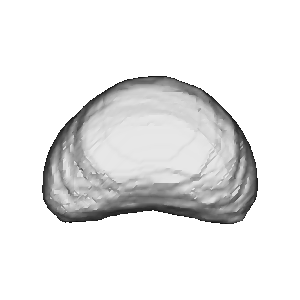

In [3]:
# Model

modelNode=slicer.modules.models.logic().AddModel(slicer.nb.localPath("Data\ProstateMeanShape.stl"))
modelNode

In [4]:
# Model with interactive rotation

from ipywidgets import interact
@interact(roll=(-90.0,90.0,5), pitch=(-90.0,90.0,5), yaw=(-90.0,90.0,5))
def update(roll=0, pitch=0, yaw=0):
    return slicer.nb.displayModel(modelNode, orientation=[roll, pitch, yaw], imageSize=[200,200])

interactive(children=(FloatSlider(value=0.0, description='roll', max=90.0, min=-90.0, step=5.0), FloatSlider(v…

In [5]:
# Transform

# Linear
transformNode = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLLinearTransformNode')
import numpy as np
slicer.util.updateTransformMatrixFromArray(transformNode, np.array([[0.5,0,0,40],[0,1.2,0,20],[0,0,3.5,50],[0,0,0,1]]))

# Non-linear
# transformNode = slicer.mrmlScene.AddNewNodeByClass('vtkMRMLGridTransformNode')

transformNode

# Interactive display
The entire view layout or selected widgets can be displayed in a cell.
Views can be shown using interactive widgets (slice scrolling, view rotation).
Rendering happens server-side (in Slicer).

IntProgress(value=0)

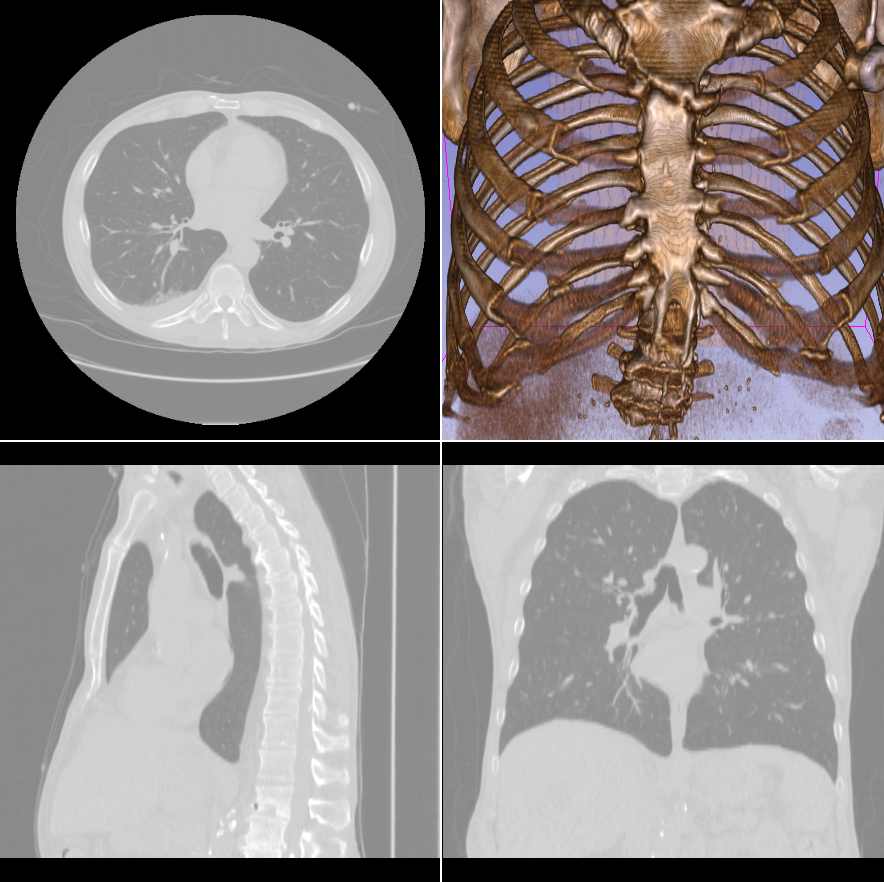

In [6]:
# Get a volume
slicer.mrmlScene.Clear()
volume = slicer.nb.downloadFromURL(
  'https://github.com/Slicer/SlicerTestingData/releases/download/SHA256/4507b664690840abb6cb9af2d919377ffc4ef75b167cb6fd0f747befdb12e38e',
  'fff.nrrd', "ct")[0]

slicer.nb.showVolumeRendering(volume)
slicer.nb.displayViews("FourUp")

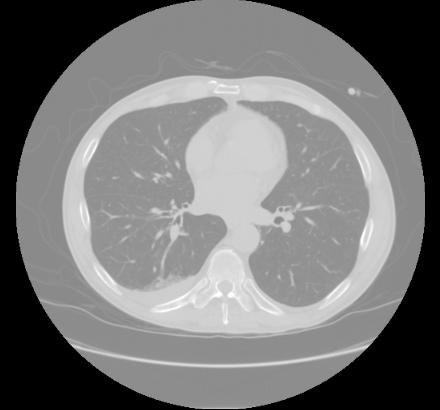

In [7]:
# Slicer view
slicer.nb.displaySliceView('Red')

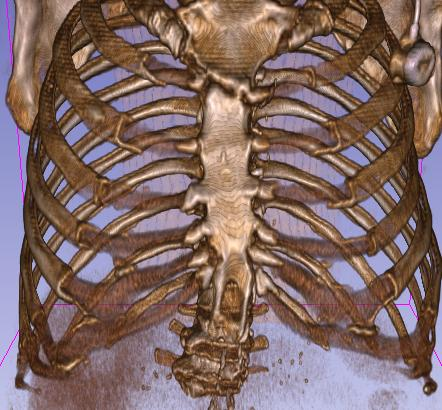

In [8]:
# 3D view
slicer.nb.display3DView()

In [9]:
# Interactive slice view
from ipywidgets import interact
@interact(position=(0,100))
def update(position=50):
    return slicer.nb.displaySliceView('Red', positionPercent=position)

interactive(children=(IntSlider(value=50, description='position'), Output()), _dom_classes=('widget-interact',…

In [10]:
# Interactive 3D view
from ipywidgets import interact

@interact(roll=(-90.0,90.0,5), pitch=(-90.0,90.0,5), yaw=(-180.0,180.0,5))
def update(roll=0, pitch=0, yaw=0):
    return slicer.nb.display3DView(0, orientation=[roll, pitch, yaw])

interactive(children=(FloatSlider(value=0.0, description='roll', max=90.0, min=-90.0, step=5.0), FloatSlider(v…

# Processing using CLI module

Creating mesh from volume...


IntProgress(value=0)

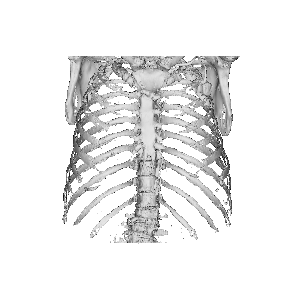

In [11]:
# Interactive CLI module execution (with progress reporting)

parameters = {}
parameters["InputVolume"] = volume.GetID()
parameters["Threshold"] = 220
outModel = slicer.vtkMRMLModelNode()
slicer.mrmlScene.AddNode( outModel )
parameters["OutputGeometry"] = outModel.GetID()
grayMaker = slicer.modules.grayscalemodelmaker
print("Creating mesh from volume...")
slicer.nb.cliRunSync(grayMaker, None, parameters)

slicer.nb.displayModel(outModel, orientation=[0,-90,0])

In [12]:
# Set CLI module parameters using interactive widget

from ipywidgets import interact_manual
@interact_manual(threshold=(-500.0,1200,5))
def h(threshold=-100):
    parameters["Threshold"] = threshold
    slicer.nb.cliRunSync(grayMaker, None, parameters)
    return slicer.nb.displayModel(outModel, orientation=[0,-90,0])

interactive(children=(FloatSlider(value=-100.0, description='threshold', max=1200.0, min=-500.0, step=5.0), Bu…

# File upload/download
Input data can be uploaded via notebook and results can be downloaded from the notebook.

In [13]:
# File download

outputFile = "segmented-model.stl"
slicer.util.saveNode(outModel, slicer.nb.localPath(outputFile))

from IPython.display import FileLink
display(FileLink(outputFile))

C:\D\SlicerNotebooks\segmented-model.stl

In [14]:
# File upload - currently not working see https://github.com/jupyter-xeus/xeus-python/issues/272
uploader=slicer.nb.FileUploadWidget()
uploader.widget

FileUpload(value={}, description='Upload')

In [ ]:
# This cell will work after file upload (above cell) is fixed
model=slicer.modules.models.logic().AddModel(uploader.path)
model

# Utility/debugging functions

In [ ]:
slicer.nb.notebookPath()

In [ ]:
__kernel_debug_enable()

In [ ]:
__kernel_debug_disable()